# diffusion

> Fill in a module description here

In [ ]:
#| default_exp diffusion

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision

from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from fastcore.foundation import L

from foundation.utils import show_img

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
mnist_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
train_dataloader = DataLoader(mnist_dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 3, 8, 2, 0, 8, 3, 5])


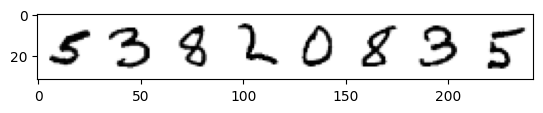

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

### Why Diffusion Process

The idea of diffusion is we sequentially add more noise to an image and then lets the model to predict what's noise it need to remove to get back the original image

### Diffusion Process

In [ ]:
img = next(iter(train_dataloader))[0][1][0]

<matplotlib.image.AxesImage>

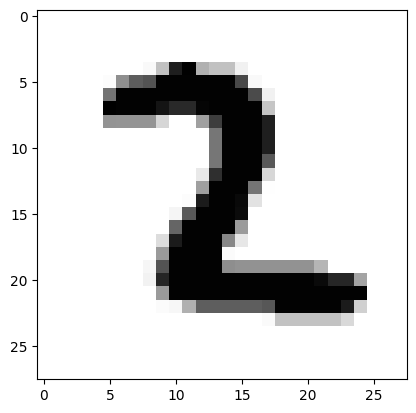

In [ ]:
show_img(img)

In [ ]:
noise = torch.randn_like(img)

<matplotlib.image.AxesImage>

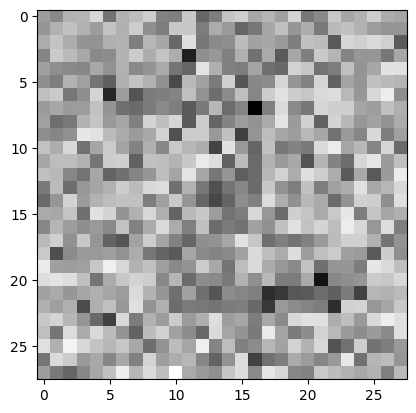

In [ ]:
show_img(img + noise)

In [ ]:
#| export
def corrupt(img, amount):
    noise = torch.randn_like(img)
    return (1-amount)*img + noise * amount

In [ ]:
amounts = torch.linspace(0, 1, steps=10)

In [ ]:
amounts

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [ ]:
corrupt_images = []

In [ ]:
for amount in amounts:
    # ipdb.set_trace()
    corrupt_images.append(corrupt(img, amount))

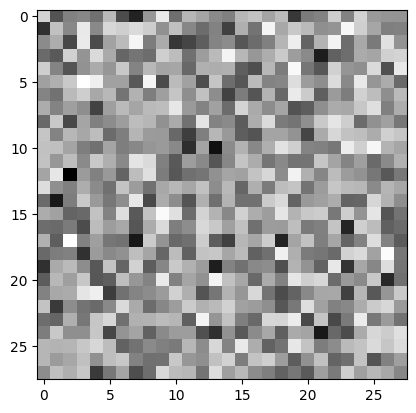

In [ ]:
for corrupt_imgage in corrupt_images:
    show_img(corrupt_imgage)

In [ ]:
torchvision.utils.make_grid(corrupt_images).shape

torch.Size([10, 28, 28])

<matplotlib.image.AxesImage>

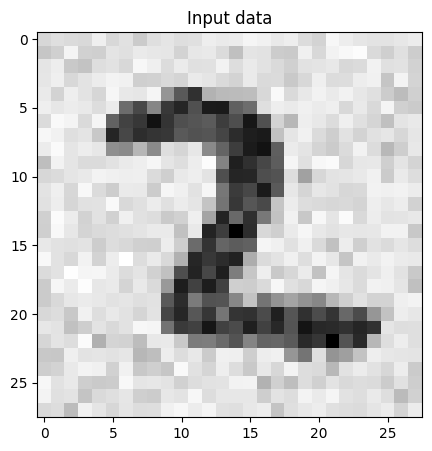

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

axs.set_title('Input data')
axs.imshow(torchvision.utils.make_grid(corrupt_images)[0], cmap='Greys')
axs.imshow(torchvision.utils.make_grid(corrupt_images)[1], cmap='Greys')

In [ ]:
axs.imshow(torchvision.utils.make_grid(corrupt_images)[5], cmap='Greys')

<matplotlib.image.AxesImage>

In [ ]:
#| export

class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            h.append(x)
            if i < 2: x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0: x = self.upscale(x)
            x += h.pop()
            x = self.act(l(x))
        return x

In [ ]:
unet = BasicUNet(1, 2)
unet(torch.rand(8, 1, 28, 28)).shape

torch.Size([8, 2, 28, 28])

In [ ]:
net = BasicUNet(1, 1)

# Feed some data through:
x.shape, net(x).shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

In [ ]:
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_basic = []